In [ ]:
# Dot Density map

In [20]:
# Importing packages 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen
import requests
from shapely.geometry import Point
from zipfile import ZipFile
import shapefile
import responses
import io
import osr
from numpy.random import RandomState, uniform
import numpy as np
from census_area import Census 
import cenpy as cen
from us import states
from shapely.geometry import Polygon

pd.options.display.max_rows = 10

In [21]:
def gen_random_points_poly(poly, num_points, seed = None):
    """
    Returns a list of N randomly generated points within a polygon. 
    """
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i=0
    while len(points) < num_points:
        s=RandomState(seed+i) if seed else RandomState(seed)
        random_point = Point([s.uniform(min_x, max_x), s.uniform(min_y, max_y)])
        if random_point.within(poly):
            points.append(random_point)
        i+=1
    return points


In [22]:
def gen_points_in_gdf_polys(geometry, values, points_per_value = None, seed = None):
    """
    Take a GeoSeries of Polygons along with a Series of values and returns randomly generated points within
    these polygons. Optionally takes a "points_per_value" integer which indicates the number of points that 
    should be generated for each 1 value.
    """
    if points_per_value:
        new_values = (values/points_per_value).astype(int)
    else:
        new_values = values
    new_values = new_values[new_values>0]
    g = gpd.GeoDataFrame(data = {'vals':new_values}, geometry = geometry)
    
    a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'], seed)),1)
    b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
    b.name='geometry'
    return b


In [23]:
def get_census_variables(year, dataset, geography, area, variables, variable_labels = None):
    """Wraps the Census API and returns a DataFrame of Census Data
    Parameters
    ----------
    year : integer
        Year representing the dataset vintage 
    dataset : string
        the name of the dataset (https://api.census.gov/data.html)
    geography : string
        the census geography
    area : dictionary
        dictionary contains the FIPS codes at each nested geographic level. For example "{'county':'001', 'state':'06'}"
    variables : list
        list of the variables to be extracted
    variable_labels : list
        optional to relabel the variable names. Must be same length as "variables"
    """
    
    base_url = 'https://api.census.gov/data/2017/acs/acs5'#.format(year, dataset)
    
    #define parameters
    get_parameter = ','.join(['NAME'] + variables)
    for_parameter = '{}:*'.format(geography)
    in_paramater = '+'.join([k+':'+v for (k,v) in area.items()])

    parameters = {'get' : get_parameter, 
                  'for' : for_parameter,
                  'in' : in_paramater}
    
    #make request specifiying url and parameters
    r = requests.get(base_url, params=parameters)
    
    #read json into pandas dataframe, specifying first row as column names
    data = r.json()
    df=pd.DataFrame(columns = data[0], data = data[1:])
    
    #identify geography fields - concatenate them into a fips code to be set as index and then delete them
    geo_fields = [x for x in df.columns if x not in ['NAME'] + variables]
    df.index = df[geo_fields].apply(lambda row: ''.join(map(str, row)), 1)
    df.index.name = 'FIPS'
    df = df.drop(geo_fields, 1)
    
    if variable_labels:
        df = df.rename(columns = dict(zip(variables, variable_labels)))
    
    #convert data numeric 
    df = df.applymap(lambda x:pd.to_numeric(x, errors='ignore'))
    return df

In [10]:
cd '/Users/aaronwoodward/Downloads/cb_2017_36_bg_500k'

/Users/aaronwoodward/Downloads/cb_2017_36_bg_500k


In [26]:
def gen_count_dot_density_map(county, pts_per_person = 300, 
                              epsg = 2163, seed=10,
                              dot_transparency=0.4, figsize=(12,12), 
                              ax=None, legend=True):
    """
    Wraps previous functions and generates population dot density maps for a specified county by race
    
    """
    #read in fips to county name relationship file
    fips = pd.read_csv('https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',
                   header=None, dtype={1:np.object, 2:np.object})
    fips['name']=fips[3]+', '+fips[0]
    fips['fips']=fips[1]+fips[2]
    
    #get name from fips if fips specified
    if county.isdigit():
        lookup = fips.set_index('fips')['name']
        county_fips = county
        name = lookup[county_fips]
    #get fips from name if name specified
    else:
        lookup = fips.set_index('name')['fips']
        name = county
        county_fips = lookup[name]
    
    
    #get geodataframe of block group shapefile
    shp_path = './cb_2017_36_bg_500k.shp'
    bgfile_name = gpd.read_file(shp_path)
    bg_geo=bgfile_name[bgfile_name['GEOID'].str[:5]==county_fips].to_crs(epsg=epsg).set_index("GEOID")['geometry']
    
    #specify variable list and variable names for the census api function
    varlist = ['B03002_003E', 
               'B03002_012E',
               'B03002_004E', 
               'B03002_006E',
               'B03002_005E',
               'B03002_007E',
               'B03002_008E',
               'B03002_009E']
    names = ['White',
             'Hispanic',
             'Black',
             'Asian',
             'AI/AN',
             'NH/PI',
             'Other_',
             'Two Plus']
    
    #Enter Census API key:
    c = Census("d06e3ffd2eb61bc6576e3fc0e6ff6f8ba6981fad")
    
    #read in block group level census variables
    dems = get_census_variables(2017, 'acs5', 'block group', 
                                {'county':county_fips[2:], 
                                 'state':county_fips[:2]}, varlist, names)
    
    #Calculate county boundaries as the union of block groups 
    union = gpd.GeoSeries(bg_geo.unary_union)
    
    #if axes object is specified, plot to this axis, otherwise create a new one
    if ax:
        union.plot(color='white', figsize=figsize, ax=ax)
    else:
        ax = union.plot(color='white', figsize=figsize)
   
    #set aspect equal and add title if specified
    ax.set(aspect='equal', xticks=[], yticks=[])
    #set title as county name
    ax.set_title(name, size=15)
    
    #annotate the dot per person ratio
    ax.annotate("1 dot = {} people".format(pts_per_person), 
                xy=(.5, .97), xycoords='axes fraction', horizontalalignment='center',
                fontsize = 12)
        
    #loop each race category and generate points for each within each block group 
    list_of_point_categories=[]
    for field in ['White','Hispanic','Black','Asian','Other_']:           
        ps=gpd.GeoDataFrame(gen_points_in_gdf_polys(geometry = bg_geo, values=dems[field],
                             points_per_value = pts_per_person, seed=seed))
        ps['field']=field
        list_of_point_categories.append(ps)
    all_points=gpd.GeoDataFrame(pd.concat(list_of_point_categories))
    all_points.plot(ax=ax, markersize=2, alpha=dot_transparency, 
              column='field', categorical=True, legend=legend)

    return ax

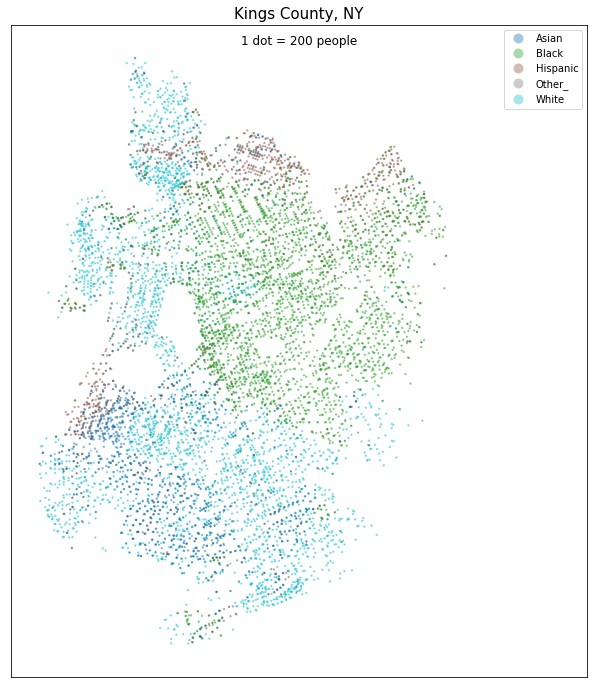

In [27]:
gen_count_dot_density_map('Kings County, NY', pts_per_person=200)

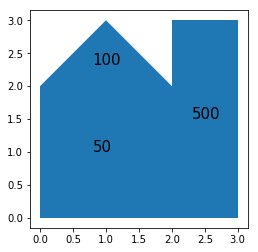

In [2]:
p1 = Polygon([[0,2],[1,3],[2,2]])
p2 = Polygon([[0,0],[0,2],[2,2],[2,0]])
p3 = Polygon([[2,0],[2,3],[3,3],[3,0]])
g = gpd.GeoSeries([p1,p2,p3])

vals = pd.Series([100, 50, 500])

ax = g.plot()
for label,loc in zip(vals, g.centroid):
    ax.text(loc.x-.2, loc.y, str(label), fontsize=15)


In [12]:
random_points = gen_points_in_gdf_polys(geometry = g, values=vals)

ax = g.plot()
random_points.plot(color='black', ax=ax, alpha=.7)

NameError: ("name 'RandomState' is not defined", 'occurred at index 0')